# Домашнее задание. Классификация изображений




В нашем тесте будет 991 картинка, для которых вам будет необходимо предсказать класс.

## Шаг 1. Установка зависимостей

####Установим необходимые библиотеки и проверим доступность CUDA

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
!nvidia-smi

Tue Nov  4 17:11:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from torchvision.transforms import v2

import torchsummary

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from collections import Counter
from torch.utils.data import WeightedRandomSampler

from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


 #### Определим константы, которые будем использовать в по ходу ноутбука

In [5]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']

# работаем на видеокарте
DEVICE = torch.device("cuda")

#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/content/train') #Path('./data/train/')
TEST_DIR = Path('/content/testset') #Path('./data/testset')

# параметры нормировки изображений по трем каналам перед подачей в модель
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = [224, 224]

## Шаг 2. Загрузка и обработка данных

#### Скачаем изображения по ссылке

In [6]:
!gdown 1RxBQiZgRAfio2tWhEE7lzZ6IaJzLheH1

Downloading...
From (original): https://drive.google.com/uc?id=1RxBQiZgRAfio2tWhEE7lzZ6IaJzLheH1
From (redirected): https://drive.google.com/uc?id=1RxBQiZgRAfio2tWhEE7lzZ6IaJzLheH1&confirm=t&uuid=dbfc00f9-9fad-4927-89b9-69a62dbdce65
To: /content/journey-springfield.zip
100% 546M/546M [00:08<00:00, 68.2MB/s]


In [7]:
!unzip -q /content/journey-springfield.zip

В train лежат данные, которые мы будем использовать для обучения модели. Изображения персонажей разложены по папкам, которые названы по именам персонажей. Названия папок мы в дальнейшем будет использовать в качестве текстовых меток классов.

В testset находятся изображения, для которых вам надо будет сделать прогноз наиболее вероятного класса.


Для обращения к файлам сформируем списки имен файлов обучающей+валидационнной и тестовой выборок. Это полные имена, включающие путь к файлам.


In [8]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Кодировать имена персонажей в числовые метки класса и обратно будем при помощи `LabelEncoder`.

Для train выборки сформируем список текстовых меток всех изображений - имя родительской директории, которая одновременно является и именем персонажа. Зададим числовые метки классов нашего энкодера при помощи метода `fit`.

Далее будем применять метод `transform` для преобразования текстовых меток в числовые, и метод `inverse_transform` для преобразования числовых меток в текстовые.


In [9]:
label_encoder = LabelEncoder()

train_val_labels = [path.parent.name for path in train_val_files]

label_encoder.fit(train_val_labels)

LabelEncoder()

Разделим train выборку на обучающую и валидационнную части. Для того, чтобы персонажи были пропорционально представлены в обучающей и валидационнной подвыборках, применим стратификацию по меткам класса.

In [10]:
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

####Создадим Datasets и Dataloaders

In [11]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, label_encoder, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.label_encoder = label_encoder
        self.len_ = len(self.files)

    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        x = self.load_image(self.files[index])
        x = self.transform_images_to_tensors(x)

        if self.mode == 'test':
            return x
        else:
            path = self.files[index]
            y = self.label_encoder.transform([path.parent.name,]).item()
            return x, y

    # принимает путь к файлу изображения и возвращает само изображение
    def load_image(self, file):
        image = Image.open(file)
        image.load()
        return image

    # преобразует изображение в тензор
    def transform_images_to_tensors(self, image):
      if self.mode == 'train':
        transform = v2.Compose([
            v2.PILToTensor(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
            #v2.ColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1),
            v2.Resize(RESCALE_SIZE),
          ])
      else:
        transform = v2.Compose([
            v2.PILToTensor(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
            v2.Resize(RESCALE_SIZE),
          ])

      tensor_transformed = transform(image)
      return(tensor_transformed)


In [12]:
train_dataset = SimpsonsDataset(train_files, label_encoder = label_encoder, mode='train')
val_dataset = SimpsonsDataset(val_files, label_encoder, mode='val')

In [13]:
batch_size = 64

In [14]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
loaders = {'train':train_loader, 'val': val_loader}

#### Посмотрим на изображения персонажей

Напишем функцию для визуализации картинок. Это аналог Imshow, которая будет принимать на вход тензоры

In [15]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Проверим, как работает наша функция. Возьмем один батч из лоадера и подадим на вход функции первый тензор из этого батча. Заодно посмотрим, как работает кодировщик меток класса.

Числовая метка класса: 15
Текстовая метка класса: ['homer_simpson']


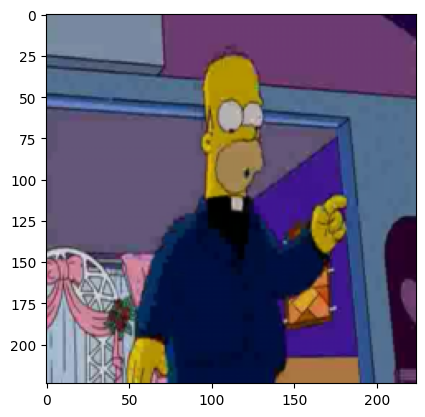

In [16]:
image_tensor, label = next(iter(train_loader))
print(f"Числовая метка класса: {label[0]}")
print(f"Текстовая метка класса: {label_encoder.inverse_transform([label[0],])}")
imshow(image_tensor[0])


In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

In [17]:
def show_images(n_rows, n_cols, dataset):
  # функция выводит изображения в n_rows рядов и n_cols столбцов
  fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4), \
                        sharey=True, sharex=True)

  for fig_x in ax.flatten(): # цикл повторяется (n_rows * n_cols) раз
    random_characters = int(np.random.uniform(0, len(dataset))) # берем случайное число в диапазоне [0; len(dataset))
    im_val, label = dataset[random_characters] # получаем изображение (тензорная форма)
    img_label = " ".join(map(lambda x: x.capitalize(), \
                             label_encoder.inverse_transform([label])[0].split('_')))  # числовую метку класса преобразуем в текстовую и немного отформатируем
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x) # отобразим изображение и метку класса с помощью написанной ранее функции imshow()
    fig_x.set_axis_off()
  return None

Запустим написанную функцию.

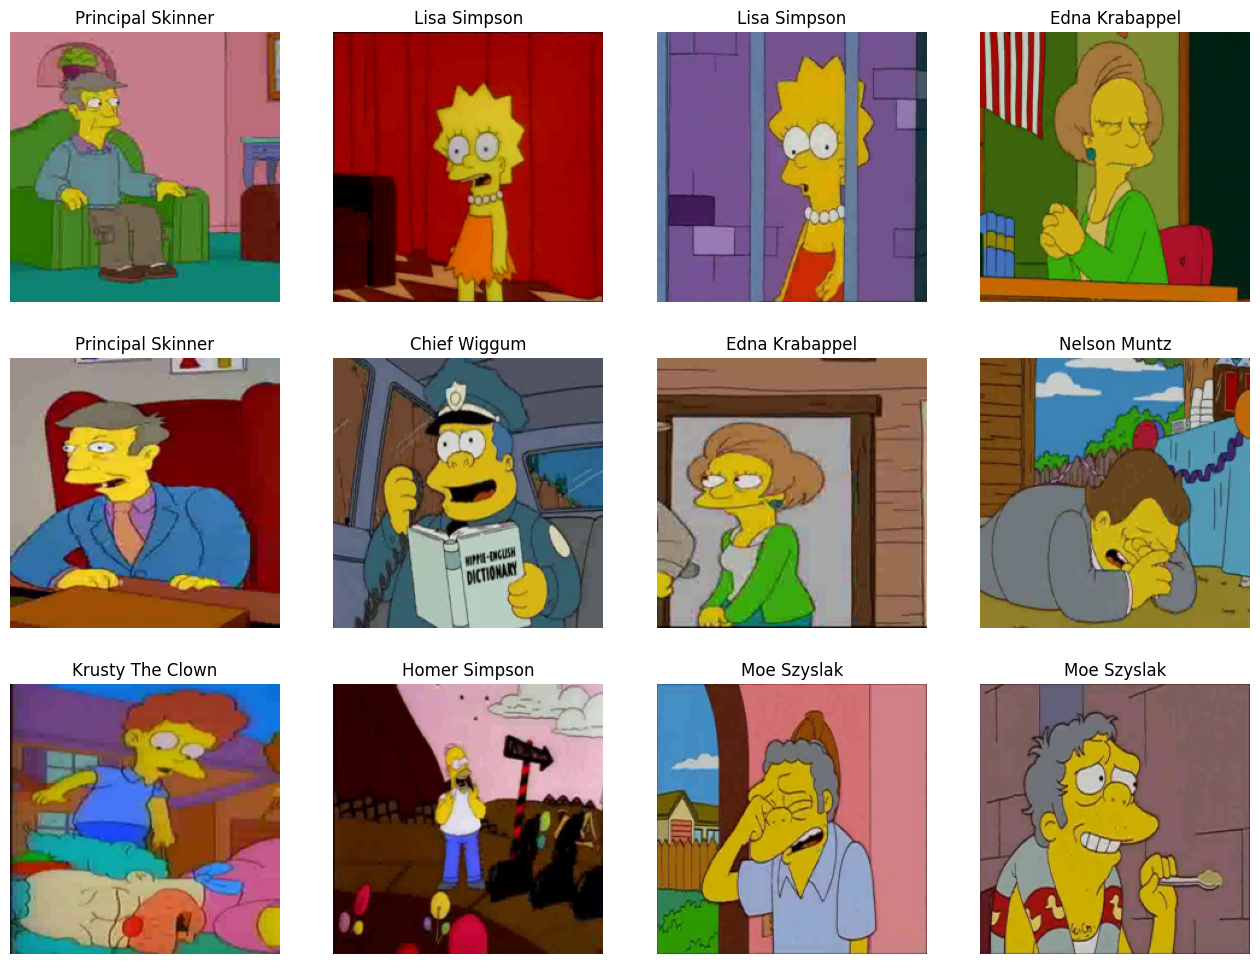

In [18]:
show_images(n_rows = 3, n_cols = 4, dataset = val_dataset)

## Шаг 3. Построение нейросети


#### Модель

In [19]:
class SimpleCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )


        self.fc = nn.Sequential(
            nn.Linear(96*5*5, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, n_classes)
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        return logits

*Описание слоев*:

1. размерность входа: $3\times 224 \times 224$
2. размерность после 1-го слоя (Conv2d + ReLU + MaxPool2d):  $8 \times 111 \times 111$
3. после 2-го слоя: $16 \times 54 \times 54$
4. после 3-го слоя: $32 \times 26 \times 26$
5. после 4-го слоя: $64 \times 12 \times 12$
6. после 5-го слоя: $96 \times 5 \times 5$
7. после полносвязного слоя (выход модели): количество классов

In [20]:
model_simple_cnn = SimpleCnn(n_classes = len(np.unique(train_val_labels)))
model_simple_cnn.to(DEVICE)
torchsummary.summary(model_simple_cnn, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             224
       BatchNorm2d-2          [-1, 8, 222, 222]              16
              ReLU-3          [-1, 8, 222, 222]               0
         MaxPool2d-4          [-1, 8, 111, 111]               0
            Conv2d-5         [-1, 16, 109, 109]           1,168
       BatchNorm2d-6         [-1, 16, 109, 109]              32
              ReLU-7         [-1, 16, 109, 109]               0
         MaxPool2d-8           [-1, 16, 54, 54]               0
            Conv2d-9           [-1, 32, 52, 52]           4,640
      BatchNorm2d-10           [-1, 32, 52, 52]              64
             ReLU-11           [-1, 32, 52, 52]               0
        MaxPool2d-12           [-1, 32, 26, 26]               0
           Conv2d-13           [-1, 64, 24, 24]          18,496
      BatchNorm2d-14           [-1, 64,

##Шаг 4. Функции для работы с моделью

#### Функция для работы с моделью

Метрика, которую необходимо оптимизировать в конкурсе -- `f1-score`.

In [21]:
from sklearn.metrics import f1_score, accuracy_score
# пример расчета: f1 = f1_score(actual_labels, y_predicted, average='micro')

В этом задании может быть полезным сделать, чтобы функция валидации и, возможно, функция обучения на одной эпохе возвращали векторы/тензоры:
- предсказанного наиболее вероятного класса
- и фактических меток класса для каждого объекта.

Сама метрика f1, при этом, будет вычисляться не внутри функции, а вне ее, сопоставляя прогнозные и фактические значения, полученные из вывода функции.

Это поможет проанализировать, при предсказании каких классов модель ошибается чаще. Также такой подход может использоваться для обнаружения изображений, которые модель классифицирует неверно.

In [22]:
def fit_one_epoch(model, train_dataloader, optimizer, loss_func):
    all_pred = []
    all_labels = []

    model.train()
    for X_batch, y_batch in tqdm(train_dataloader):
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        optimizer.zero_grad()
        outp = model(X_batch)
        loss = loss_func(outp, y_batch)

        loss.backward()
        optimizer.step()

        preds = outp.argmax(-1)
        all_pred.append(preds.cpu())
        all_labels.append(y_batch.cpu())

    all_pred = torch.cat(all_pred)
    all_labels = torch.cat(all_labels)
    return all_pred, all_labels

In [23]:
def eval_one_epoch(model, val_dataloader):
    all_preds = []
    all_labels = []

    model.eval()
    for X_batch, y_batch in tqdm(val_dataloader):
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        with torch.no_grad():
            outp = model(X_batch)
            preds = outp.argmax(-1)

        all_preds.append(preds.cpu())
        all_labels.append(y_batch.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    return all_preds, all_labels

In [24]:
def train_func(model, num_epochs, dataloaders, optimizer, loss_func, lr_scheduler):
    metrics = {"train_f1": [], "valid_f1": []}

    train_preds_all = None
    train_labels_all = None
    val_preds_all = None
    val_labels_all = None
    for epoch in range(num_epochs):
        print(f"\nEpoch: {epoch+1}")

        train_preds, train_labels = fit_one_epoch(model = model, train_dataloader = dataloaders['train'], optimizer = optimizer, loss_func = loss_func)
        train_preds_all = train_preds
        train_labels_all = train_labels

        train_f1 = f1_score(train_labels, train_preds, average='micro')
        print(f"Train F1: {train_f1:.4f}\n")

        val_preds, val_labels = eval_one_epoch(model = model, val_dataloader = dataloaders['val'])
        val_preds_all = val_preds
        val_labels_all = val_labels

        val_f1 = f1_score(val_labels, val_preds, average='micro')
        print(f"Validation F1: {val_f1:.4f}\n")

        lr_scheduler.step()

        metrics["train_f1"].append(train_f1)
        metrics["valid_f1"].append(val_f1)
    return metrics, {
        'train_preds': train_preds_all,
        'train_labels': train_labels_all,
        'val_preds': val_preds_all,
        'val_labels': val_labels_all
    }

## Шаг 5. Применение модели к данным

#### Применение модели к данным

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_simple_cnn.parameters(), lr=0.001, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

Запустите обучение сети

In [ ]:
metrics_simple_cnn, predictions = train_func(model = model_simple_cnn, num_epochs = 6, dataloaders = loaders, optimizer = optimizer, loss_func = criterion, lr_scheduler=lr_scheduler)


Epoch: 1


100%|██████████| 246/246 [02:19<00:00,  1.76it/s]


Train F1: 0.4509



100%|██████████| 82/82 [00:40<00:00,  2.04it/s]


Validation F1: 0.5951


Epoch: 2


100%|██████████| 246/246 [02:12<00:00,  1.85it/s]


Train F1: 0.6638



100%|██████████| 82/82 [00:39<00:00,  2.05it/s]


Validation F1: 0.6549


Epoch: 3


100%|██████████| 246/246 [02:12<00:00,  1.85it/s]


Train F1: 0.7636



100%|██████████| 82/82 [00:40<00:00,  2.00it/s]


Validation F1: 0.7679


Epoch: 4


100%|██████████| 246/246 [02:17<00:00,  1.78it/s]


Train F1: 0.7948



100%|██████████| 82/82 [00:40<00:00,  2.05it/s]


Validation F1: 0.7820


Epoch: 5


100%|██████████| 246/246 [02:12<00:00,  1.86it/s]


Train F1: 0.8400



100%|██████████| 82/82 [00:41<00:00,  1.99it/s]


Validation F1: 0.7969


Epoch: 6


100%|██████████| 246/246 [02:12<00:00,  1.86it/s]


Train F1: 0.8544



100%|██████████| 82/82 [00:39<00:00,  2.07it/s]

Validation F1: 0.8170



(опционально) Постройте график динамики метрик модели по ходу обучения

Final Valid F1-micro: 0.8170


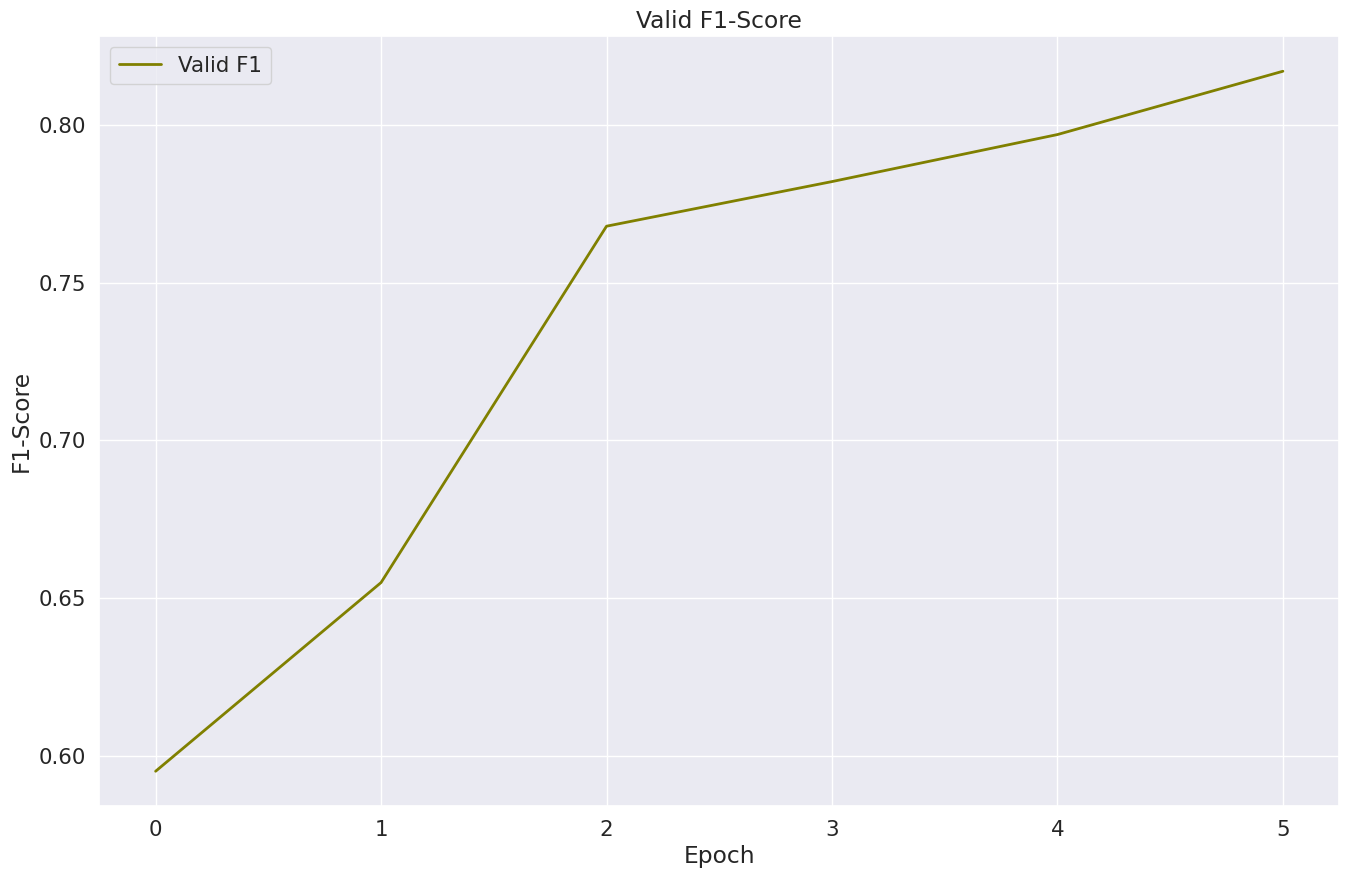

In [ ]:
valid_f1 = metrics_simple_cnn["valid_f1"]

print(f"Final Valid F1-micro: {valid_f1[-1]:.4f}")

sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid F1-Score")
plt.plot(range(len(valid_f1)), valid_f1, label="Valid F1", linewidth=2, color='olive')
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.legend()
plt.grid(True)
plt.show()


результат плохой, 0.817 очень мало

###Ищем плохо предсказанных симпсонов

In [ ]:
class_names = list(label_encoder.classes_)
val_preds = predictions['val_preds']
val_labels = predictions['val_labels']

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(val_labels, val_preds, target_names=class_names))

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.81      0.74      0.77       228
           agnes_skinner       1.00      0.10      0.18        10
  apu_nahasapeemapetilon       0.90      0.88      0.89       156
           barney_gumble       0.89      0.31      0.46        26
            bart_simpson       0.72      0.77      0.74       336
            carl_carlson       0.80      0.67      0.73        24
charles_montgomery_burns       0.80      0.74      0.77       298
            chief_wiggum       0.91      0.89      0.90       247
         cletus_spuckler       1.00      0.17      0.29        12
          comic_book_guy       0.67      0.80      0.73       117
               disco_stu       0.00      0.00      0.00         2
          edna_krabappel       0.85      0.76      0.81       114
                fat_tony       0.00      0.00      0.00         7
                     gil       1.00      0.29      0.44         7
    groun

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
f1_per_class = f1_score(val_labels, val_preds, average=None)

worst_indices = np.argsort(f1_per_class)[:10]
worst_classes = [class_names[i] for i in worst_indices]

print("Худшие классы:")
for idx in worst_indices:
    print(f"{class_names[idx]}: F1 = {f1_per_class[idx]:.4f}")


Худшие классы:
fat_tony: F1 = 0.0000
disco_stu: F1 = 0.0000
miss_hoover: F1 = 0.0000
lionel_hutz: F1 = 0.0000
troy_mcclure: F1 = 0.0000
sideshow_mel: F1 = 0.1538
agnes_skinner: F1 = 0.1818
snake_jailbird: F1 = 0.2353
professor_john_frink: F1 = 0.2609
cletus_spuckler: F1 = 0.2857


In [ ]:
class_counts = Counter(train_val_labels)

print("Количество примеров для худших классов:")
for class_name in worst_classes:
    count = class_counts.get(class_name, 0)
    print(f"{class_name}: {count} примеров")

Количество примеров для худших классов:
fat_tony: 27 примеров
disco_stu: 8 примеров
miss_hoover: 17 примеров
lionel_hutz: 3 примеров
troy_mcclure: 8 примеров
sideshow_mel: 40 примеров
agnes_skinner: 42 примеров
snake_jailbird: 55 примеров
professor_john_frink: 65 примеров
cletus_spuckler: 47 примеров


In [26]:
train_val_files_filtered = [
    path for path in train_val_files]
new_label_encoder = LabelEncoder()
train_val_filtered_labels = [path.parent.name for path in train_val_files_filtered]
new_label_encoder.fit(train_val_filtered_labels)

train_files, val_files = train_test_split(
    train_val_files_filtered,
    test_size=0.25, stratify=train_val_filtered_labels
)

In [27]:
worst_classes = ["fat_tony", "miss_hoover", "professor_john_frink","snake_jailbird", "cletus_spuckler", "agnes_skinner", "sideshow_mel"]
worst_classes = [str(name) for name in worst_classes]

###Перепишем датасет

In [28]:
class NewSimpsonsDataset(Dataset):
    def __init__(self, files, label_encoder, mode, worst_classes=None):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.label_encoder = label_encoder
        self.len_ = len(self.files)
        self.worst_classes = worst_classes if worst_classes else []

    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        file_path = self.files[index]
        class_name = file_path.parent.name

        x = self.load_image(file_path)
        x = self.transform_images_to_tensors(x, class_name)

        if self.mode == 'test':
            return x
        else:
            y = self.label_encoder.transform([class_name]).item()
            return x, y

    def load_image(self, file):
        image = Image.open(file)
        image.load()
        return image

    def transform_images_to_tensors(self, image, class_name):
        if self.mode == 'train':
            if class_name in self.worst_classes:
                transform = v2.Compose([
                    v2.PILToTensor(),
                    v2.ToDtype(torch.float32, scale=True),

                    v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
                    v2.RandomRotation(30),
                    v2.RandomHorizontalFlip(),
                    v2.RandomAffine(degrees=0, translate=(0.15, 0.15)),

                    v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
                    v2.Resize(RESCALE_SIZE),
                ])
            else:
                transform = v2.Compose([
                    v2.PILToTensor(),
                    v2.ToDtype(torch.float32, scale=True),
                    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                    v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
                    v2.Resize(RESCALE_SIZE),
                ])
        else:
            transform = v2.Compose([
                v2.PILToTensor(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
                v2.Resize(RESCALE_SIZE),
            ])

        tensor_transformed = transform(image)
        return tensor_transformed


Пересоздам датасеты с редкими классами

In [29]:
train_dataset = NewSimpsonsDataset(
    files=train_files,
    label_encoder=new_label_encoder,
    mode='train',
    worst_classes=worst_classes
)

val_dataset = NewSimpsonsDataset(
    files=val_files,
    label_encoder=new_label_encoder,
    mode='val',
    worst_classes=worst_classes
)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
loaders = {'train': train_dataloader, 'val': val_dataloader}

###Обучим модель на новых данных

In [30]:
n_classes = len(new_label_encoder.classes_)

In [31]:
model2_simple_cnn = SimpleCnn(n_classes = n_classes)
model2_simple_cnn.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model2_simple_cnn.parameters(), lr=0.001, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [ ]:
metrics2_simple_cnn, predictions2 = train_func(model = model2_simple_cnn, num_epochs = 7, dataloaders = loaders, optimizer = optimizer, loss_func = criterion, lr_scheduler=lr_scheduler)


Epoch: 1


100%|██████████| 246/246 [03:10<00:00,  1.29it/s]


Train F1: 0.4620



100%|██████████| 82/82 [00:39<00:00,  2.06it/s]


Validation F1: 0.5976


Epoch: 2


100%|██████████| 246/246 [03:09<00:00,  1.30it/s]


Train F1: 0.6696



100%|██████████| 82/82 [00:40<00:00,  2.04it/s]


Validation F1: 0.6925


Epoch: 3


100%|██████████| 246/246 [03:08<00:00,  1.30it/s]


Train F1: 0.7605



100%|██████████| 82/82 [00:41<00:00,  1.98it/s]


Validation F1: 0.7571


Epoch: 4


100%|██████████| 246/246 [03:14<00:00,  1.26it/s]


Train F1: 0.7935



100%|██████████| 82/82 [00:40<00:00,  2.03it/s]


Validation F1: 0.7933


Epoch: 5


100%|██████████| 246/246 [03:10<00:00,  1.29it/s]


Train F1: 0.8340



100%|██████████| 82/82 [00:40<00:00,  2.03it/s]


Validation F1: 0.8168


Epoch: 6


100%|██████████| 246/246 [03:11<00:00,  1.28it/s]


Train F1: 0.8496



100%|██████████| 82/82 [00:39<00:00,  2.07it/s]


Validation F1: 0.8214


Epoch: 7


100%|██████████| 246/246 [03:08<00:00,  1.30it/s]


Train F1: 0.8676



100%|██████████| 82/82 [00:40<00:00,  2.03it/s]

Validation F1: 0.8298



Уже лучше - 0.83. Но всё равно плохо. Добавлю WeightedSampler

###Обучим модель с WeightedSampler+Аугментация

In [32]:
train_labels = [str(path.parent.name) for path in train_files]
class_counts = Counter(train_labels)
max_count = max(class_counts.values())

class_weights = {cls: max_count / count for cls, count in class_counts.items()}
sample_weights = torch.DoubleTensor([class_weights[label] for label in train_labels])

sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_dataloader = DataLoader(train_dataset, batch_size=32, sampler = sampler)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
loaders = {'train': train_dataloader, 'val': val_dataloader}

In [33]:
model3_simple_cnn = SimpleCnn(n_classes = n_classes)
model3_simple_cnn.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model3_simple_cnn.parameters(), lr=0.001, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [ ]:
metrics3_simple_cnn, predictions3 = train_func(model = model3_simple_cnn, num_epochs = 7, dataloaders = loaders, optimizer = optimizer, loss_func = criterion, lr_scheduler=lr_scheduler)


Epoch: 1


100%|██████████| 491/491 [03:09<00:00,  2.59it/s]


Train F1: 0.5164



100%|██████████| 164/164 [00:39<00:00,  4.15it/s]


Validation F1: 0.5862


Epoch: 2


100%|██████████| 491/491 [03:09<00:00,  2.59it/s]


Train F1: 0.7455



100%|██████████| 164/164 [00:39<00:00,  4.17it/s]


Validation F1: 0.7158


Epoch: 3


100%|██████████| 491/491 [03:19<00:00,  2.46it/s]


Train F1: 0.8288



100%|██████████| 164/164 [00:39<00:00,  4.18it/s]


Validation F1: 0.7455


Epoch: 4


100%|██████████| 491/491 [03:10<00:00,  2.58it/s]


Train F1: 0.8602



100%|██████████| 164/164 [00:48<00:00,  3.40it/s]


Validation F1: 0.7596


Epoch: 5


100%|██████████| 491/491 [03:18<00:00,  2.48it/s]


Train F1: 0.8883



100%|██████████| 164/164 [00:39<00:00,  4.11it/s]


Validation F1: 0.7870


Epoch: 6


100%|██████████| 491/491 [03:18<00:00,  2.47it/s]


Train F1: 0.9011



100%|██████████| 164/164 [00:39<00:00,  4.16it/s]


Validation F1: 0.7944


Epoch: 7


 25%|██▌       | 125/491 [00:48<02:23,  2.55it/s]


KeyboardInterrupt: 

Модель переобучается


###Изменим немного архитектуру и батчи

In [34]:
class MidCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, padding = 1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )


        self.fc = nn.Sequential(
            nn.Linear(96*7*7, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, n_classes)
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        return logits

In [35]:
train_dataloader = DataLoader(train_dataset, batch_size=64, sampler = sampler)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
loaders = {'train': train_dataloader, 'val': val_dataloader}

In [36]:
model_mid_cnn = MidCnn(n_classes=n_classes)
model_mid_cnn.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_mid_cnn.parameters(), lr=0.003, weight_decay=0.01)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [ ]:
metrics_mid_cnn, predictions_mid = train_func(model = model_mid_cnn, num_epochs = 6, dataloaders = loaders, optimizer = optimizer, loss_func = criterion, lr_scheduler=lr_scheduler)


Epoch: 1


100%|██████████| 246/246 [03:21<00:00,  1.22it/s]


Train F1: 0.5828



100%|██████████| 82/82 [00:40<00:00,  2.02it/s]


Validation F1: 0.5894


Epoch: 2


100%|██████████| 246/246 [03:15<00:00,  1.26it/s]


Train F1: 0.7924



100%|██████████| 82/82 [00:42<00:00,  1.94it/s]


Validation F1: 0.6798


Epoch: 3


100%|██████████| 246/246 [03:15<00:00,  1.26it/s]


Train F1: 0.8785



100%|██████████| 82/82 [00:40<00:00,  2.01it/s]


Validation F1: 0.7598


Epoch: 4


100%|██████████| 246/246 [03:16<00:00,  1.25it/s]


Train F1: 0.9025



100%|██████████| 82/82 [00:42<00:00,  1.95it/s]


Validation F1: 0.7816


Epoch: 5


100%|██████████| 246/246 [03:18<00:00,  1.24it/s]


Train F1: 0.9328



100%|██████████| 82/82 [00:40<00:00,  2.03it/s]


Validation F1: 0.8095


Epoch: 6


100%|██████████| 246/246 [03:42<00:00,  1.11it/s]


Train F1: 0.9443



100%|██████████| 82/82 [00:41<00:00,  2.00it/s]

Validation F1: 0.8244



Всё еще сильное переобучение. К результатам после первого изменения не приблизился

###Пробую в последний раз без WeightedSampler

In [37]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
loaders = {'train': train_dataloader, 'val': val_dataloader}

In [38]:
model_mid2_cnn = MidCnn(n_classes=n_classes)
model_mid2_cnn.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_mid2_cnn.parameters(), lr=0.001, weight_decay=0.01)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [ ]:
metrics_mid2_cnn, predictions_mid2 = train_func(model = model_mid2_cnn, num_epochs = 6, dataloaders = loaders, optimizer = optimizer, loss_func = criterion, lr_scheduler=lr_scheduler)


Epoch: 1


100%|██████████| 246/246 [03:19<00:00,  1.23it/s]


Train F1: 0.5121



100%|██████████| 82/82 [00:41<00:00,  1.99it/s]


Validation F1: 0.6708


Epoch: 2


100%|██████████| 246/246 [03:17<00:00,  1.25it/s]


Train F1: 0.7099



100%|██████████| 82/82 [00:41<00:00,  1.98it/s]


Validation F1: 0.7511


Epoch: 3


100%|██████████| 246/246 [03:14<00:00,  1.27it/s]


Train F1: 0.8057



100%|██████████| 82/82 [00:40<00:00,  2.03it/s]


Validation F1: 0.8154


Epoch: 4


100%|██████████| 246/246 [03:12<00:00,  1.28it/s]


Train F1: 0.8519



100%|██████████| 82/82 [00:40<00:00,  2.03it/s]


Validation F1: 0.8286


Epoch: 5


100%|██████████| 246/246 [03:13<00:00,  1.27it/s]


Train F1: 0.8976



100%|██████████| 82/82 [00:40<00:00,  2.00it/s]


Validation F1: 0.8496


Epoch: 6


100%|██████████| 246/246 [03:16<00:00,  1.25it/s]


Train F1: 0.9166



100%|██████████| 82/82 [00:40<00:00,  2.03it/s]

Validation F1: 0.8556



0.856 - лучший результат, полученный мной без fine-tuning

P.S. На сабмите вышло 0.93198

## Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах.

In [39]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

@torch.no_grad()
def show_images2(n_rows, n_cols, dataset, model):
  # функция выводит изображения в n_rows рядов и n_cols столбцов
  fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4), \
                        sharey=True, sharex=True)

  for fig_x in axs.flatten(): # цикл повторяется (n_rows * n_cols) раз
    random_characters = int(np.random.uniform(0, len(dataset))) # берем случайное число в диапазоне [0; len(dataset))
    im_val, label = dataset[random_characters] # выводим изображение (тензорная форма)
    img_label = " ".join(map(lambda x: x.capitalize(), \
                             label_encoder.inverse_transform([label])[0].split('_')))  # числовую метку класса преобразуем в текстовую и немного отформатируем
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x) # отобразим изображение и метку класса с помощью написанной ранее функции imshow()

    # ниже представлен код для добавления на изображение подписи с вероятностью класса
    actual_text = "Actual : {}".format(img_label)


    font0 = FontProperties()
    font = font0.copy()

    # наша модель возвращает логиты, поэтому для получения вероятностей классов не забываем применить softmax:
    prob_pred = nn.functional.softmax(model(im_val.unsqueeze(0).to(DEVICE)), dim = -1).cpu().numpy()

    predicted_proba = np.max(prob_pred)*100 # берем максимальную вероятность класса
    y_pred = np.argmax(prob_pred) # берем числовую метку класса, для которого вероятность максимальна

    predicted_label = " ".join(map(lambda x: x.capitalize(), \
                             label_encoder.inverse_transform([y_pred])[0].split('_')))
    predicted_text = "{}:\n {:.1f}%".format(predicted_label, predicted_proba)

    fig_x.add_patch(patches.Rectangle((0, 190), 7*len(predicted_label), 25,color='white'))
    fig_x.text(2, 195, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')
    fig_x.set_axis_off()

  return None

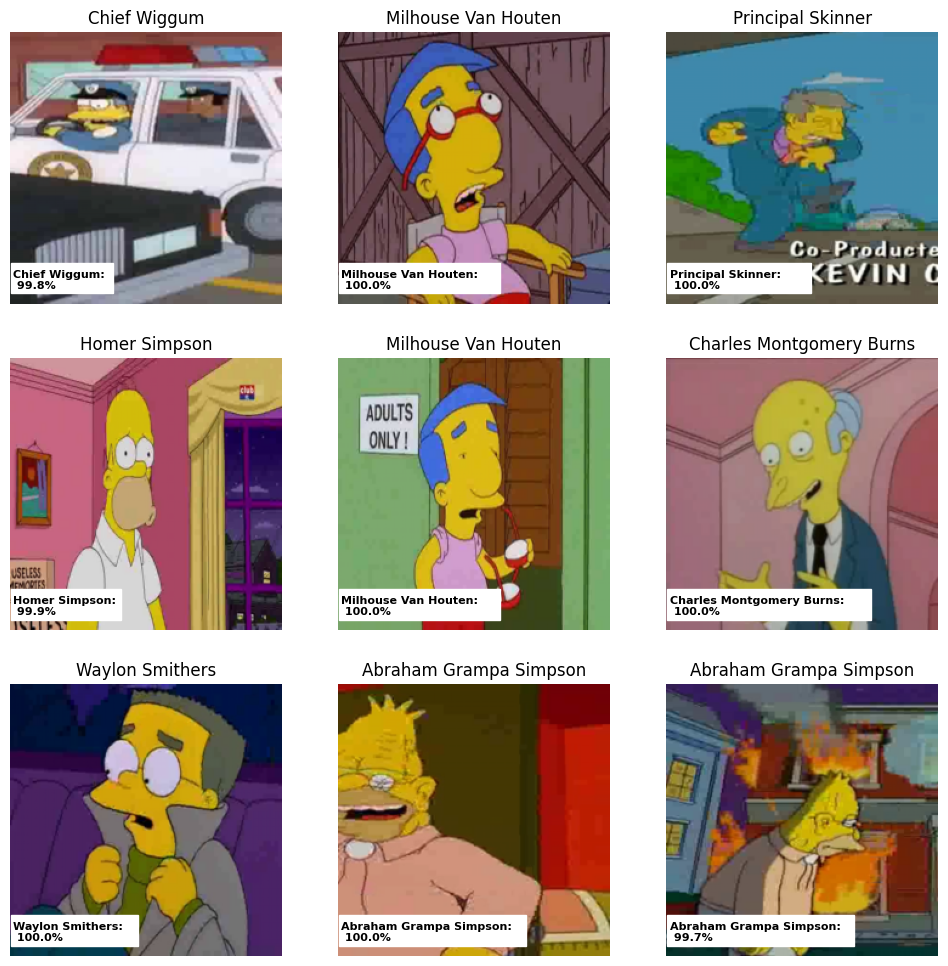

In [57]:
show_images2(n_rows = 3, n_cols = 3, dataset = val_dataset, model = model_mid2_cnn)

## Шаг 6. Submit на Kaggle

Создадим loader для тестовых данных

In [40]:
test_dataset = SimpsonsDataset(test_files, label_encoder = label_encoder, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

Воспользуемся функцией predict, которая возвращает предсказанные числовые метки для всех объектов в лоадере.

In [41]:
def predict(model, loader):
    model.eval()
    all_predictions = torch.tensor([]).to(DEVICE).int()
    print("Test mode...")
    for inputs in tqdm_notebook(loader):
        inputs = inputs.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)

            predictions = outputs.argmax(-1).int()
            all_predictions = torch.cat((all_predictions, predictions), 0)
    return all_predictions.cpu()

Получем предсказание меток классов для тестовых данных:

In [42]:
predicted_numeric_labels = predict(model_mid2_cnn, test_loader)

Test mode...


  0%|          | 0/16 [00:00<?, ?it/s]

и преобразуем их в текстовые метки:

In [ ]:
predicted_text_labels = label_encoder.inverse_transform(predicted_numeric_labels)

Загрузим пример файла для загрузки на Kaggle

In [ ]:
import pandas as pd
sample_submission = pd.read_csv("/content/sample_submission.csv")
sample_submission.head(10)

Id      Expected
0  img0.jpg  bart_simpson
1  img1.jpg  bart_simpson
2  img2.jpg  bart_simpson
3  img3.jpg  bart_simpson
4  img4.jpg  bart_simpson
5  img5.jpg  bart_simpson
6  img6.jpg  bart_simpson
7  img7.jpg  bart_simpson
8  img8.jpg  bart_simpson
9  img9.jpg  bart_simpson

In [ ]:
my_submission = pd.DataFrame({'Id': [path.name for path in test_files], 'Expected': predicted_text_labels})
my_submission.head(10)

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon
5  img102.jpg           kent_brockman
6  img103.jpg          edna_krabappel
7  img104.jpg            chief_wiggum
8  img105.jpg            lisa_simpson
9  img106.jpg           kent_brockman

In [ ]:
my_submission.to_csv('simple_cnn_baseline.csv', index=False)

##Fine-tuning

In [43]:
from torchvision import models
from torchvision.transforms import transforms
from transformers import get_linear_schedule_with_warmup
from torchvision.models import resnet50

In [46]:
model = resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, n_classes)
)

model.to(DEVICE)

optimizer = torch.optim.AdamW(
    list(model.layer4.parameters()) + list(model.fc.parameters()),
    lr=0.0005,
    weight_decay=0.001
)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=6,
    eta_min=1e-6
)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
)

loaders = {'train': train_dataloader, 'val': val_dataloader}

In [48]:
metrics_resnet, predictions_resnet = train_func(
    model=model,
    num_epochs=6,
    dataloaders=loaders,
    optimizer=optimizer,
    loss_func=criterion,
    lr_scheduler=lr_scheduler
)


Epoch: 1


100%|██████████| 246/246 [04:04<00:00,  1.00it/s]


Train F1: 0.8637



100%|██████████| 82/82 [00:53<00:00,  1.54it/s]


Validation F1: 0.9005


Epoch: 2


100%|██████████| 246/246 [03:56<00:00,  1.04it/s]


Train F1: 0.9542



100%|██████████| 82/82 [00:54<00:00,  1.52it/s]


Validation F1: 0.9347


Epoch: 3


100%|██████████| 246/246 [04:01<00:00,  1.02it/s]


Train F1: 0.9801



100%|██████████| 82/82 [00:53<00:00,  1.53it/s]


Validation F1: 0.9438


Epoch: 4


100%|██████████| 246/246 [03:58<00:00,  1.03it/s]


Train F1: 0.9948



100%|██████████| 82/82 [00:53<00:00,  1.54it/s]


Validation F1: 0.9511


Epoch: 5


100%|██████████| 246/246 [03:56<00:00,  1.04it/s]


Train F1: 0.9977



100%|██████████| 82/82 [00:53<00:00,  1.52it/s]


Validation F1: 0.9536


Epoch: 6


100%|██████████| 246/246 [03:56<00:00,  1.04it/s]


Train F1: 0.9989



100%|██████████| 82/82 [00:52<00:00,  1.55it/s]

Validation F1: 0.9557



Фантастический результат

In [49]:
predicted_numeric_labels = predict(model, test_loader)

Test mode...


  0%|          | 0/16 [00:00<?, ?it/s]

In [50]:
predicted_text_labels = label_encoder.inverse_transform(predicted_numeric_labels)

In [51]:
import pandas as pd
sample_submission = pd.read_csv("/content/sample_submission.csv")
sample_submission.head(10)

Id      Expected
0  img0.jpg  bart_simpson
1  img1.jpg  bart_simpson
2  img2.jpg  bart_simpson
3  img3.jpg  bart_simpson
4  img4.jpg  bart_simpson
5  img5.jpg  bart_simpson
6  img6.jpg  bart_simpson
7  img7.jpg  bart_simpson
8  img8.jpg  bart_simpson
9  img9.jpg  bart_simpson

In [52]:
my_submission = pd.DataFrame({'Id': [path.name for path in test_files], 'Expected': predicted_text_labels})
my_submission.head(10)

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon
5  img102.jpg           kent_brockman
6  img103.jpg          edna_krabappel
7  img104.jpg            chief_wiggum
8  img105.jpg            lisa_simpson
9  img106.jpg           kent_brockman

In [53]:
my_submission.to_csv('resnet_baseline.csv', index=False)

In [61]:
torch.save(model.state_dict(), 'best_resnet50.pth')

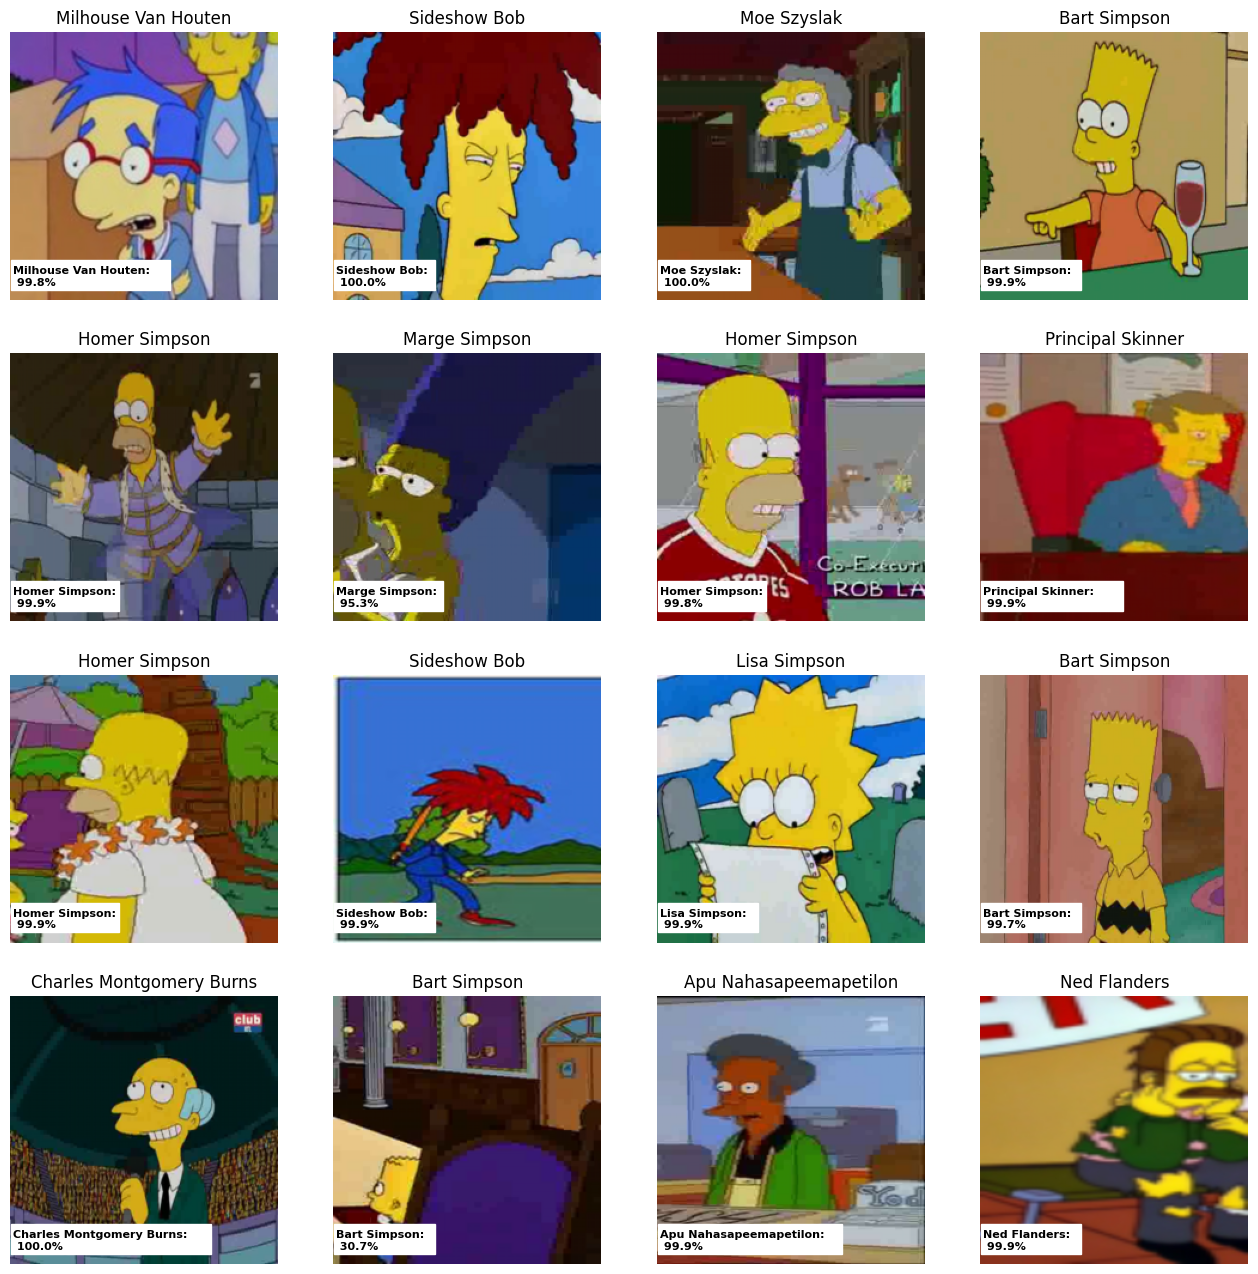

In [60]:
show_images2(n_rows = 4, n_cols = 4, dataset = val_dataset, model = model)